In [1]:
import numpy as np
import matplotlib.pyplot as plt
from img_preprocessing import get_full_frame
from keras.models import load_model
from keras.optimizers import Adam, SGD

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
val_den = np.load("./data/mall_processed/val-densities-small-blur.npy")
train_den = np.load("./data/mall_processed/train-densities-small-blur.npy")
val_imgs = np.load("./data/mall_processed/val-imgs.npy")
train_imgs = np.load("./data/mall_processed/train-imgs.npy")

In [5]:
large_column_path = "./large_column/final.h5"
small_column_path = "./small_column/final.h5"

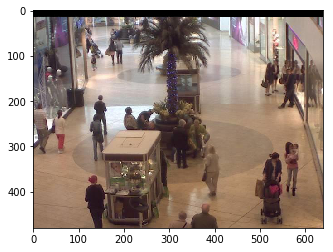

In [21]:
plt.imshow(train_imgs[0])

29000.000000000004

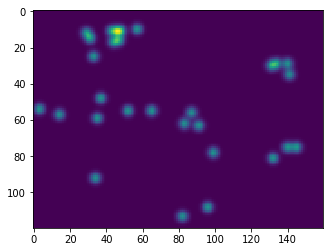

In [22]:
plt.imshow(train_den[0].reshape(train_den.shape[1], train_den.shape[2]))
np.sum(train_den[0])

In [2]:
from keras.models import Model
from keras.layers import Input, Conv2D, Concatenate
import large_column_architecture
import small_column_architecture
from keras.callbacks import EarlyStopping, ModelCheckpoint
from loss import den_loss
from loss import den_loss_abs as abs_diff
import keras.losses
keras.losses.den_loss_sqr = den_loss
keras.losses.den_loss_abs = abs_diff

In [3]:
input_img = Input(shape=(480, 640, 3), name="multi_input")

In [10]:
large_column_model = Model(large_column_architecture.input_img, large_column_architecture.out)
large_column_model.load_weights(large_column_path)
large_column_model.layers.pop(0)
lc_output = large_column_model(input_img)

small_column_model = Model(small_column_architecture.input_img, small_column_architecture.out)
small_column_model.load_weights(small_column_path)
small_column_model.layers.pop(0)
sc_output = small_column_model(input_img)

In [14]:
comb = Concatenate()([sc_output, lc_output])
out = Conv2D(1, (1,1), activation='relu', padding="same", name="output")(comb)

In [17]:
multi_column_model = Model(input_img, out)

In [18]:
class AccuracyStopper(keras.callbacks.Callback):
    def __init__(self, look_back=5, target_slope=0.1):
        self.look_back = look_back
        self.target_slope = target_slope
    
    def on_train_begin(self, logs={}):
        self.acc = []
        self.epoch_count = 0

    def on_epoch_end(self, batch, logs={}):
        self.epoch_count += 1
        self.acc.append(logs.get('val_den_loss_abs'))
        if self.epoch_count >= self.look_back:
            acc_slope = 0
            acc_slope = (self.acc[self.epoch_count-1] - self.acc[self.epoch_count-self.look_back])/self.look_back
            print(" - abs_diff_slope: {}".format(acc_slope))
            if acc_slope < self.target_slope:
                print("abs_diff_slope is past the target_slope. Stopping training.")
                self.model.stop_training = True
        
acc_callback = AccuracyStopper(look_back=4, target_slope=0.1)
filepath="./multi_column/checkpoints/multi_column_weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=False, mode='max')
early_stopper = EarlyStopping(patience=0, monitor="val_loss")

In [19]:
callbacks_list = [early_stopper, checkpoint]
optimizer = Adam(lr=0.0000001)
#optimizer = SGD(lr=0.001)
multi_column_model.compile(optimizer=optimizer, loss=den_loss)
multi_column_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
multi_input (InputLayer)        (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 120, 160, 1)  25249       multi_input[0][0]                
__________________________________________________________________________________________________
model_5 (Model)                 (None, 120, 160, 1)  107701      multi_input[0][0]                
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 120, 160, 2)  0           model_6[1][0]                    
                                                                 model_5[1][0]                    
__________

In [ ]:
history = multi_column_model.fit(train_imgs, train_den, epochs=1000, batch_size=10, validation_data=(val_imgs, val_den), callbacks=callbacks_list)

In [28]:
from keras.utils import plot_model
plot_model(multi_column_model, to_file='./multi_column/model.png', show_shapes=True, show_layer_names=True)